# Convolutional Neural Network

This example shows how to design a simple quantization aware training CNN and how to measure 
the maximum accumulator bit width. We also show the impact of quantization on accuracy. 

To analyze the potential FHE-compatible quantization configurations, we use the simulation mode of
 the FHE circuit of the CNN. The maximum accumulator 
bit width that is currently allowed in Concrete ML is **16** bits, which limits the bit-widths 
that are usable for weights and activations.

We find an FHE compatible configuration for 3 bits weights and activations and run the CNN in FHE.
The accuracy in this highly quantized configuration is 92%. 

### Import required modules

In [1]:
import time

import numpy as np
import torch
import torch.utils
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

# And some helpers for visualization.

%matplotlib inline

import matplotlib.pyplot as plt

### Load the data-set and visualize it

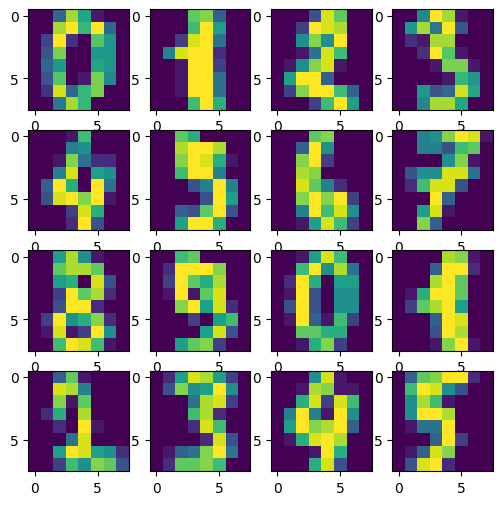

In [2]:
X, y = load_digits(return_X_y=True)

# The sklearn Digits data-set, though it contains digit images, keeps these images in vectors
# so we need to reshape them to 2D first. The images are 8x8 px in size and monochrome
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

### Define the neural network

Since the accumulator bit width in FHE is small, we prune the convolutional
filters to limit the number of connections per neuron.

Neural network **pruning** is the process by which the synapses of individual neurons in a layer
are forced to have a weight equal to zero. This basically eliminates them from the computation 
and thus they do not increase the accumulator bit width. It has been shown that neural networks can 
maintain their accuracy with a degree of pruning that can 
even exceed 70% for some over-parametrized networks such as VGG16 or large ResNets.

See: https://arxiv.org/pdf/2003.03033.pdf, Figure 8 in Section 7.2, for an evaluation on the 
simple pruning method used in this example.

In [3]:
class TinyCNN(nn.Module):
    """A very small CNN to classify the sklearn digits data-set."""

    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        # This network has a total complexity of 1216 MAC
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, 2, stride=1, padding=0)
        self.fc1 = nn.Linear(32, n_classes)

    def forward(self, x):
        """Run inference on the tiny CNN, apply the decision layer on the reshaped conv output."""
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

### Train the CNN

Note that the training code for quantization aware training is the same as it would be for
floating point training. Indeed, the Brevitas layers used in the CNN class will handle
quantization during training. 

We train the network for varying weights and activations bit-width, to find an FHE compatible 
configuration.

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   1%|          | 1/150 [00:00<00:18,  8.23it/s]

Training:   1%|▏         | 2/150 [00:00<00:17,  8.59it/s]

Training:   2%|▏         | 3/150 [00:00<00:16,  8.73it/s]

Training:   3%|▎         | 4/150 [00:00<00:16,  8.81it/s]

Training:   3%|▎         | 5/150 [00:00<00:16,  8.72it/s]

Training:   4%|▍         | 6/150 [00:00<00:16,  8.78it/s]

Training:   5%|▍         | 7/150 [00:00<00:16,  8.82it/s]

Training:   5%|▌         | 8/150 [00:00<00:16,  8.85it/s]

Training:   6%|▌         | 9/150 [00:01<00:15,  8.88it/s]

Training:   7%|▋         | 10/150 [00:01<00:15,  8.90it/s]

Training:   7%|▋         | 11/150 [00:01<00:15,  8.91it/s]

Training:   8%|▊         | 12/150 [00:01<00:15,  8.90it/s]

Training:   9%|▊         | 13/150 [00:01<00:15,  8.86it/s]

Training:   9%|▉         | 14/150 [00:01<00:15,  8.88it/s]

Training:  10%|█         | 15/150 [00:01<00:15,  8.87it/s]

Training:  11%|█         | 16/150 [00:01<00:15,  8.86it/s]

Training:  11%|█▏        | 17/150 [00:01<00:14,  8.88it/s]

Training:  12%|█▏        | 18/150 [00:02<00:14,  8.86it/s]

Training:  13%|█▎        | 19/150 [00:02<00:14,  8.88it/s]

Training:  13%|█▎        | 20/150 [00:02<00:14,  8.83it/s]

Training:  14%|█▍        | 21/150 [00:02<00:14,  8.82it/s]

Training:  15%|█▍        | 22/150 [00:02<00:14,  8.86it/s]

Training:  15%|█▌        | 23/150 [00:02<00:14,  8.89it/s]

Training:  16%|█▌        | 24/150 [00:02<00:14,  8.87it/s]

Training:  17%|█▋        | 25/150 [00:02<00:14,  8.91it/s]

Training:  17%|█▋        | 26/150 [00:02<00:13,  8.91it/s]

Training:  18%|█▊        | 27/150 [00:03<00:13,  8.91it/s]

Training:  19%|█▊        | 28/150 [00:03<00:13,  8.90it/s]

Training:  19%|█▉        | 29/150 [00:03<00:13,  8.87it/s]

Training:  20%|██        | 30/150 [00:03<00:13,  8.92it/s]

Training:  21%|██        | 31/150 [00:03<00:13,  8.95it/s]

Training:  21%|██▏       | 32/150 [00:03<00:13,  8.98it/s]

Training:  22%|██▏       | 33/150 [00:03<00:13,  9.00it/s]

Training:  23%|██▎       | 34/150 [00:03<00:12,  8.97it/s]

Training:  23%|██▎       | 35/150 [00:03<00:12,  8.95it/s]

Training:  24%|██▍       | 36/150 [00:04<00:12,  8.97it/s]

Training:  25%|██▍       | 37/150 [00:04<00:12,  8.94it/s]

Training:  25%|██▌       | 38/150 [00:04<00:12,  8.99it/s]

Training:  26%|██▌       | 39/150 [00:04<00:12,  9.00it/s]

Training:  27%|██▋       | 40/150 [00:04<00:12,  8.99it/s]

Training:  27%|██▋       | 41/150 [00:04<00:12,  8.98it/s]

Training:  28%|██▊       | 42/150 [00:04<00:12,  8.96it/s]

Training:  29%|██▊       | 43/150 [00:04<00:11,  8.97it/s]

Training:  29%|██▉       | 44/150 [00:04<00:11,  8.97it/s]

Training:  30%|███       | 45/150 [00:05<00:11,  8.93it/s]

Training:  31%|███       | 46/150 [00:05<00:11,  8.95it/s]

Training:  31%|███▏      | 47/150 [00:05<00:11,  8.98it/s]

Training:  32%|███▏      | 48/150 [00:05<00:11,  8.97it/s]

Training:  33%|███▎      | 49/150 [00:05<00:11,  8.98it/s]

Training:  33%|███▎      | 50/150 [00:05<00:11,  8.98it/s]

Training:  34%|███▍      | 51/150 [00:05<00:11,  8.98it/s]

Training:  35%|███▍      | 52/150 [00:05<00:10,  9.01it/s]

Training:  35%|███▌      | 53/150 [00:05<00:10,  8.94it/s]

Training:  36%|███▌      | 54/150 [00:06<00:10,  8.80it/s]

Training:  37%|███▋      | 55/150 [00:06<00:10,  8.86it/s]

Training:  37%|███▋      | 56/150 [00:06<00:10,  8.89it/s]

Training:  38%|███▊      | 57/150 [00:06<00:10,  8.94it/s]

Training:  39%|███▊      | 58/150 [00:06<00:10,  8.96it/s]

Training:  39%|███▉      | 59/150 [00:06<00:10,  8.95it/s]

Training:  40%|████      | 60/150 [00:06<00:10,  8.94it/s]

Training:  41%|████      | 61/150 [00:06<00:10,  8.86it/s]

Training:  41%|████▏     | 62/150 [00:06<00:09,  8.90it/s]

Training:  42%|████▏     | 63/150 [00:07<00:09,  8.92it/s]

Training:  43%|████▎     | 64/150 [00:07<00:09,  9.04it/s]

Training:  43%|████▎     | 65/150 [00:07<00:09,  9.14it/s]

Training:  44%|████▍     | 66/150 [00:07<00:09,  9.17it/s]

Training:  45%|████▍     | 67/150 [00:07<00:09,  9.18it/s]

Training:  45%|████▌     | 68/150 [00:07<00:08,  9.16it/s]

Training:  46%|████▌     | 69/150 [00:07<00:08,  9.18it/s]

Training:  47%|████▋     | 70/150 [00:07<00:08,  9.27it/s]

Training:  47%|████▋     | 71/150 [00:07<00:08,  9.33it/s]

Training:  48%|████▊     | 72/150 [00:08<00:08,  9.17it/s]

Training:  49%|████▊     | 73/150 [00:08<00:08,  9.18it/s]

Training:  49%|████▉     | 74/150 [00:08<00:08,  9.17it/s]

Training:  50%|█████     | 75/150 [00:08<00:08,  9.24it/s]

Training:  51%|█████     | 76/150 [00:08<00:07,  9.29it/s]

Training:  51%|█████▏    | 77/150 [00:08<00:07,  9.13it/s]

Training:  52%|█████▏    | 78/150 [00:08<00:07,  9.22it/s]

Training:  53%|█████▎    | 79/150 [00:08<00:07,  9.28it/s]

Training:  53%|█████▎    | 80/150 [00:08<00:07,  9.14it/s]

Training:  54%|█████▍    | 81/150 [00:09<00:07,  9.02it/s]

Training:  55%|█████▍    | 82/150 [00:09<00:07,  9.02it/s]

Training:  55%|█████▌    | 83/150 [00:09<00:07,  9.04it/s]

Training:  56%|█████▌    | 84/150 [00:09<00:07,  9.15it/s]

Training:  57%|█████▋    | 85/150 [00:09<00:07,  8.91it/s]

Training:  57%|█████▋    | 86/150 [00:09<00:07,  8.95it/s]

Training:  58%|█████▊    | 87/150 [00:09<00:06,  9.07it/s]

Training:  59%|█████▊    | 88/150 [00:09<00:06,  9.22it/s]

Training:  59%|█████▉    | 89/150 [00:09<00:06,  9.19it/s]

Training:  60%|██████    | 90/150 [00:10<00:06,  9.24it/s]

Training:  61%|██████    | 91/150 [00:10<00:06,  9.24it/s]

Training:  61%|██████▏   | 92/150 [00:10<00:06,  9.11it/s]

Training:  62%|██████▏   | 93/150 [00:10<00:06,  9.09it/s]

Training:  63%|██████▎   | 94/150 [00:10<00:06,  9.17it/s]

Training:  63%|██████▎   | 95/150 [00:10<00:05,  9.19it/s]

Training:  64%|██████▍   | 96/150 [00:10<00:05,  9.21it/s]

Training:  65%|██████▍   | 97/150 [00:10<00:05,  9.27it/s]

Training:  65%|██████▌   | 98/150 [00:10<00:05,  9.28it/s]

Training:  66%|██████▌   | 99/150 [00:10<00:05,  9.26it/s]

Training:  67%|██████▋   | 100/150 [00:11<00:05,  9.26it/s]

Training:  67%|██████▋   | 101/150 [00:11<00:05,  9.30it/s]

Training:  68%|██████▊   | 102/150 [00:11<00:05,  9.37it/s]

Training:  69%|██████▊   | 103/150 [00:11<00:05,  9.33it/s]

Training:  69%|██████▉   | 104/150 [00:11<00:04,  9.40it/s]

Training:  70%|███████   | 105/150 [00:11<00:04,  9.46it/s]

Training:  71%|███████   | 106/150 [00:11<00:04,  9.45it/s]

Training:  71%|███████▏  | 107/150 [00:11<00:04,  9.30it/s]

Training:  72%|███████▏  | 108/150 [00:11<00:04,  9.24it/s]

Training:  73%|███████▎  | 109/150 [00:12<00:04,  9.28it/s]

Training:  73%|███████▎  | 110/150 [00:12<00:04,  9.33it/s]

Training:  74%|███████▍  | 111/150 [00:12<00:04,  9.40it/s]

Training:  75%|███████▍  | 112/150 [00:12<00:04,  9.38it/s]

Training:  75%|███████▌  | 113/150 [00:12<00:03,  9.38it/s]

Training:  76%|███████▌  | 114/150 [00:12<00:03,  9.35it/s]

Training:  77%|███████▋  | 115/150 [00:12<00:03,  9.37it/s]

Training:  77%|███████▋  | 116/150 [00:12<00:03,  9.38it/s]

Training:  78%|███████▊  | 117/150 [00:12<00:03,  9.32it/s]

Training:  79%|███████▊  | 118/150 [00:13<00:03,  9.29it/s]

Training:  79%|███████▉  | 119/150 [00:13<00:03,  9.28it/s]

Training:  80%|████████  | 120/150 [00:13<00:03,  9.28it/s]

Training:  81%|████████  | 121/150 [00:13<00:03,  9.17it/s]

Training:  81%|████████▏ | 122/150 [00:13<00:03,  9.17it/s]

Training:  82%|████████▏ | 123/150 [00:13<00:02,  9.20it/s]

Training:  83%|████████▎ | 124/150 [00:13<00:02,  9.20it/s]

Training:  83%|████████▎ | 125/150 [00:13<00:02,  9.14it/s]

Training:  84%|████████▍ | 126/150 [00:13<00:02,  9.17it/s]

Training:  85%|████████▍ | 127/150 [00:14<00:02,  9.09it/s]

Training:  85%|████████▌ | 128/150 [00:14<00:02,  9.13it/s]

Training:  86%|████████▌ | 129/150 [00:14<00:02,  8.93it/s]

Training:  87%|████████▋ | 130/150 [00:14<00:02,  9.00it/s]

Training:  87%|████████▋ | 131/150 [00:14<00:02,  9.07it/s]

Training:  88%|████████▊ | 132/150 [00:14<00:01,  9.04it/s]

Training:  89%|████████▊ | 133/150 [00:14<00:01,  9.04it/s]

Training:  89%|████████▉ | 134/150 [00:14<00:01,  8.94it/s]

Training:  90%|█████████ | 135/150 [00:14<00:01,  9.06it/s]

Training:  91%|█████████ | 136/150 [00:15<00:01,  9.12it/s]

Training:  91%|█████████▏| 137/150 [00:15<00:01,  9.08it/s]

Training:  92%|█████████▏| 138/150 [00:15<00:01,  9.17it/s]

Training:  93%|█████████▎| 139/150 [00:15<00:01,  9.19it/s]

Training:  93%|█████████▎| 140/150 [00:15<00:01,  9.17it/s]

Training:  94%|█████████▍| 141/150 [00:15<00:00,  9.16it/s]

Training:  95%|█████████▍| 142/150 [00:15<00:00,  9.20it/s]

Training:  95%|█████████▌| 143/150 [00:15<00:00,  9.16it/s]

Training:  96%|█████████▌| 144/150 [00:15<00:00,  9.20it/s]

Training:  97%|█████████▋| 145/150 [00:15<00:00,  9.18it/s]

Training:  97%|█████████▋| 146/150 [00:16<00:00,  9.15it/s]

Training:  98%|█████████▊| 147/150 [00:16<00:00,  9.17it/s]

Training:  99%|█████████▊| 148/150 [00:16<00:00,  9.10it/s]

Training:  99%|█████████▉| 149/150 [00:16<00:00,  9.08it/s]

Training: 100%|██████████| 150/150 [00:16<00:00,  9.12it/s]

Training: 100%|██████████| 150/150 [00:16<00:00,  9.07it/s]

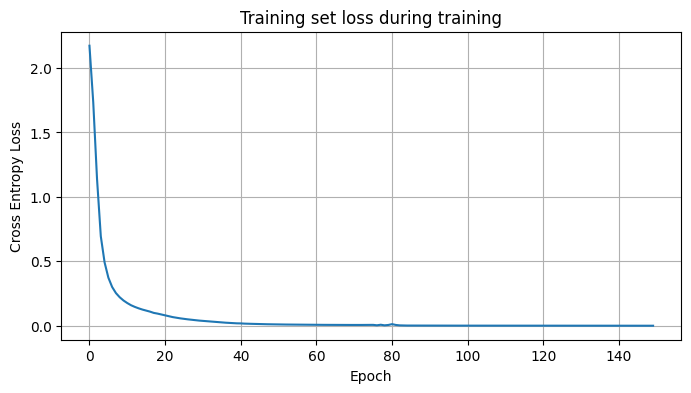

In [4]:
torch.manual_seed(42)


def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)


# Create the tiny CNN with 10 output classes
N_EPOCHS = 150

# Create a train data loader
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

# Create a test data loader to supply batches for network evaluation (test)
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

# Train the network with Adam, output the test set accuracy every epoch
net = TinyCNN(10)
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_dataloader))

fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

### Test the torch network in fp32

In [5]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy for fp32 weights and activations: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


test_torch(net, test_dataloader)

Test accuracy for fp32 weights and activations: 98.22%


### Define the Concrete ML testing function

We introduce the `test_with_concrete` function which allows us to test a Concrete ML model in one of two modes:
- in FHE
- in the clear, using simulated FHE execution

Note that it is trivial to toggle between between the two modes. 

In [6]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

### Test the network using Simulation

Note that this is not a test in FHE. The simulated FHE mode gives 
insight about the impact of FHE execution on the accuracy.

The torch neural network is converted to FHE by Concrete ML using a dedicated function, `compile_torch_model`.

In [7]:
n_bits = 6

q_module = compile_torch_model(net, x_train, rounding_threshold_bits=6, p_error=0.1)

start_time = time.time()
accs = test_with_concrete(
    q_module,
    test_dataloader,
    use_sim=True,
)
sim_time = time.time() - start_time

print(f"Simulated FHE execution for {n_bits} bit network accuracy: {accs:.2f}%")

  0%|          | 0/450 [00:00<?, ?it/s]

  6%|▌         | 25/450 [00:00<00:01, 248.54it/s]

 11%|█         | 50/450 [00:00<00:01, 249.22it/s]

 17%|█▋        | 75/450 [00:00<00:01, 249.43it/s]

 22%|██▏       | 101/450 [00:00<00:01, 250.33it/s]

 28%|██▊       | 127/450 [00:00<00:01, 250.25it/s]

 34%|███▍      | 153/450 [00:00<00:01, 250.00it/s]

 40%|███▉      | 179/450 [00:00<00:01, 249.73it/s]

 45%|████▌     | 204/450 [00:00<00:00, 249.29it/s]

 51%|█████     | 230/450 [00:00<00:00, 249.73it/s]

 57%|█████▋    | 255/450 [00:01<00:00, 249.10it/s]

 62%|██████▏   | 280/450 [00:01<00:00, 249.21it/s]

 68%|██████▊   | 305/450 [00:01<00:00, 248.50it/s]

 73%|███████▎  | 330/450 [00:01<00:00, 247.97it/s]

 79%|███████▉  | 355/450 [00:01<00:00, 248.17it/s]

 84%|████████▍ | 380/450 [00:01<00:00, 248.22it/s]

 90%|█████████ | 406/450 [00:01<00:00, 249.31it/s]

 96%|█████████▌| 431/450 [00:01<00:00, 248.91it/s]

100%|██████████| 450/450 [00:01<00:00, 249.13it/s]

Simulated FHE execution for 6 bit network accuracy: 0.98%


### Generate Keys

In [8]:
# Generate keys first
t = time.time()
q_module.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

Keygen time: 1.01s


### 3. Execute in FHE on encrypted data

In [9]:
# Run inference in FHE on a single encrypted example
mini_test_dataset = TensorDataset(torch.Tensor(x_test[:100, :]), torch.Tensor(y_test[:100]))
mini_test_dataloader = DataLoader(mini_test_dataset)

t = time.time()
accuracy_test = test_with_concrete(
    q_module,
    mini_test_dataloader,
    use_sim=False,
)
elapsed_time = time.time() - t
time_per_inference = elapsed_time / len(mini_test_dataset)
accuracy_percentage = 100 * accuracy_test

print(
    f"Time per inference in FHE: {time_per_inference:.2f} "
    f"with {accuracy_percentage:.2f}% accuracy"
)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<04:26,  2.69s/it]

  2%|▏         | 2/100 [00:05<04:04,  2.49s/it]

  3%|▎         | 3/100 [00:13<08:37,  5.33s/it]

  4%|▍         | 4/100 [00:16<06:45,  4.22s/it]

  5%|▌         | 5/100 [00:18<05:39,  3.58s/it]

  6%|▌         | 6/100 [00:22<05:58,  3.81s/it]

  7%|▋         | 7/100 [00:30<07:47,  5.03s/it]

  8%|▊         | 8/100 [00:33<06:30,  4.24s/it]

  9%|▉         | 9/100 [00:35<05:39,  3.73s/it]

 10%|█         | 10/100 [00:38<05:01,  3.35s/it]

 11%|█         | 11/100 [00:45<06:37,  4.46s/it]

 12%|█▏        | 12/100 [00:47<05:40,  3.87s/it]

 13%|█▎        | 13/100 [00:50<05:00,  3.45s/it]

 14%|█▍        | 14/100 [00:52<04:33,  3.18s/it]

 15%|█▌        | 15/100 [00:55<04:12,  2.97s/it]

 16%|█▌        | 16/100 [00:57<03:57,  2.83s/it]

 17%|█▋        | 17/100 [01:00<03:45,  2.72s/it]

 18%|█▊        | 18/100 [01:02<03:37,  2.65s/it]

 19%|█▉        | 19/100 [01:05<03:30,  2.60s/it]

 20%|██        | 20/100 [01:07<03:31,  2.65s/it]

 21%|██        | 21/100 [01:10<03:25,  2.60s/it]

 22%|██▏       | 22/100 [01:12<03:20,  2.56s/it]

 23%|██▎       | 23/100 [01:15<03:15,  2.54s/it]

 24%|██▍       | 24/100 [01:17<03:11,  2.52s/it]

 25%|██▌       | 25/100 [01:20<03:08,  2.51s/it]

 26%|██▌       | 26/100 [01:22<03:05,  2.51s/it]

 27%|██▋       | 27/100 [01:25<03:02,  2.50s/it]

 28%|██▊       | 28/100 [01:27<02:59,  2.49s/it]

 29%|██▉       | 29/100 [01:30<02:56,  2.49s/it]

 30%|███       | 30/100 [01:32<02:54,  2.49s/it]

 31%|███       | 31/100 [01:35<02:51,  2.48s/it]

 32%|███▏      | 32/100 [01:37<02:48,  2.48s/it]

 33%|███▎      | 33/100 [01:41<03:08,  2.81s/it]

 34%|███▍      | 34/100 [01:44<03:06,  2.83s/it]

 35%|███▌      | 35/100 [01:47<03:12,  2.96s/it]

 36%|███▌      | 36/100 [01:49<03:01,  2.83s/it]

 37%|███▋      | 37/100 [01:52<02:51,  2.73s/it]

 38%|███▊      | 38/100 [01:54<02:44,  2.65s/it]

 39%|███▉      | 39/100 [01:57<02:38,  2.60s/it]

 40%|████      | 40/100 [01:59<02:34,  2.58s/it]

 41%|████      | 41/100 [02:02<02:30,  2.55s/it]

 42%|████▏     | 42/100 [02:04<02:26,  2.52s/it]

 43%|████▎     | 43/100 [02:07<02:22,  2.51s/it]

 44%|████▍     | 44/100 [02:09<02:21,  2.52s/it]

 45%|████▌     | 45/100 [02:12<02:17,  2.50s/it]

 46%|████▌     | 46/100 [02:14<02:14,  2.49s/it]

 47%|████▋     | 47/100 [02:17<02:11,  2.48s/it]

 48%|████▊     | 48/100 [02:19<02:08,  2.47s/it]

 49%|████▉     | 49/100 [02:22<02:05,  2.47s/it]

 50%|█████     | 50/100 [02:24<02:03,  2.46s/it]

 51%|█████     | 51/100 [02:27<02:00,  2.46s/it]

 52%|█████▏    | 52/100 [02:29<01:57,  2.46s/it]

 53%|█████▎    | 53/100 [02:31<01:55,  2.46s/it]

 54%|█████▍    | 54/100 [02:34<01:52,  2.46s/it]

 55%|█████▌    | 55/100 [02:36<01:50,  2.46s/it]

 56%|█████▌    | 56/100 [02:40<02:03,  2.82s/it]

 57%|█████▋    | 57/100 [02:44<02:21,  3.29s/it]

 58%|█████▊    | 58/100 [02:48<02:20,  3.34s/it]

 59%|█████▉    | 59/100 [02:50<02:06,  3.10s/it]

 60%|██████    | 60/100 [02:53<01:56,  2.91s/it]

 61%|██████    | 61/100 [02:55<01:48,  2.78s/it]

 62%|██████▏   | 62/100 [02:58<01:41,  2.68s/it]

 63%|██████▎   | 63/100 [03:00<01:36,  2.62s/it]

 64%|██████▍   | 64/100 [03:03<01:35,  2.65s/it]

 65%|██████▌   | 65/100 [03:05<01:31,  2.60s/it]

 66%|██████▌   | 66/100 [03:08<01:27,  2.56s/it]

 67%|██████▋   | 67/100 [03:10<01:23,  2.54s/it]

 68%|██████▊   | 68/100 [03:13<01:20,  2.52s/it]

 69%|██████▉   | 69/100 [03:15<01:17,  2.51s/it]

 70%|███████   | 70/100 [03:18<01:14,  2.50s/it]

 71%|███████   | 71/100 [03:20<01:12,  2.49s/it]

 72%|███████▏  | 72/100 [03:23<01:09,  2.49s/it]

 73%|███████▎  | 73/100 [03:25<01:07,  2.48s/it]

 74%|███████▍  | 74/100 [03:28<01:04,  2.48s/it]

 75%|███████▌  | 75/100 [03:30<01:01,  2.48s/it]

 76%|███████▌  | 76/100 [03:33<00:59,  2.48s/it]

 77%|███████▋  | 77/100 [03:35<00:57,  2.48s/it]

 78%|███████▊  | 78/100 [03:38<00:54,  2.48s/it]

 79%|███████▉  | 79/100 [03:40<00:52,  2.48s/it]

 80%|████████  | 80/100 [03:43<00:49,  2.48s/it]

 81%|████████  | 81/100 [03:45<00:47,  2.48s/it]

 82%|████████▏ | 82/100 [03:48<00:44,  2.48s/it]

 83%|████████▎ | 83/100 [03:50<00:42,  2.48s/it]

 84%|████████▍ | 84/100 [03:53<00:39,  2.48s/it]

 85%|████████▌ | 85/100 [03:55<00:37,  2.48s/it]

 86%|████████▌ | 86/100 [03:58<00:34,  2.48s/it]

 87%|████████▋ | 87/100 [04:00<00:32,  2.48s/it]

 88%|████████▊ | 88/100 [04:02<00:29,  2.48s/it]

 89%|████████▉ | 89/100 [04:05<00:27,  2.48s/it]

 90%|█████████ | 90/100 [04:07<00:24,  2.49s/it]

 91%|█████████ | 91/100 [04:11<00:23,  2.67s/it]

 92%|█████████▏| 92/100 [04:13<00:20,  2.62s/it]

 93%|█████████▎| 93/100 [04:16<00:18,  2.59s/it]

 94%|█████████▍| 94/100 [04:20<00:18,  3.06s/it]

 95%|█████████▌| 95/100 [04:23<00:15,  3.09s/it]

 96%|█████████▌| 96/100 [04:25<00:11,  2.93s/it]

 97%|█████████▋| 97/100 [04:28<00:08,  2.80s/it]

 98%|█████████▊| 98/100 [04:30<00:05,  2.70s/it]

 99%|█████████▉| 99/100 [04:33<00:02,  2.64s/it]

100%|██████████| 100/100 [04:35<00:00,  2.59s/it]

100%|██████████| 100/100 [04:35<00:00,  2.76s/it]

Time per inference in FHE: 2.76 with 100.00% accuracy


### Conclusion

In this example, a simple CNN model is trained with torch and reach 98% accuracy in clear. The model is then converted to FHE and evaluated over 100 samples in FHE.

The model in FHE achieves **the same accuracy** as the original torch model with a FHE execution time of **2.9 seconds** per image.